# Model 1 ~ What sport are we most likely to succeed in?

In order to answer this question we will split this up in two smaller questions which we will be tackling individually:

1. **Which sport should we participate in the Olympics in?:**

2. **What probability do we have of winning a medal at a given sport?:**

First step however is to do some basic data pre-processing steps to adjust the data set to our benefit and obtain better final results (most of these data processing steps are done based on our own logic and considering that these steps would improve  our models).

We will be going step by step throughout this notebook, explaining at every step what we are doing and why.

We would also like to highlight that we have leveraged on a kaggle notebook which also looked into the first subquestion. We have used a lot of his/her ideas and code, but have extended the model based on two main things:

- Include additional feature (medals won per country per sport)
- Divide models based on sex

The kaggle notebook can be found under: https://www.kaggle.com/deanpower/what-sport-will-you-compete-in

Reviewing this notebook has allowed us to better understand how to do a "real" machine learning notebook and we consider we have been able to learn a lot from it despite having copied a lot of it's ideas.

##### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import model1_funcs as M1
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
pd.options.mode.chained_assignment = None  # default='warn'

##### Read data

In [3]:
df = pd.read_csv('data/athlete_events.csv', index_col=0)

In [4]:
df.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


##### Basic explanatory analysis

In [5]:
df.describe()

,Age,Height,Weight,Year
count,261642.000000,210945.000000,208241.000000,271116.000000
mean,25.556898,175.338970,70.702393,1978.378480
std,6.393561,10.518462,14.348020,29.877632
min,10.000000,127.000000,25.000000,1896.000000
25%,21.000000,168.000000,60.000000,1960.000000
50%,24.000000,175.000000,70.000000,1988.000000
75%,28.000000,183.000000,79.000000,2002.000000
max,97.000000,226.000000,214.000000,2016.000000


In [6]:
df.isna().sum()

Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

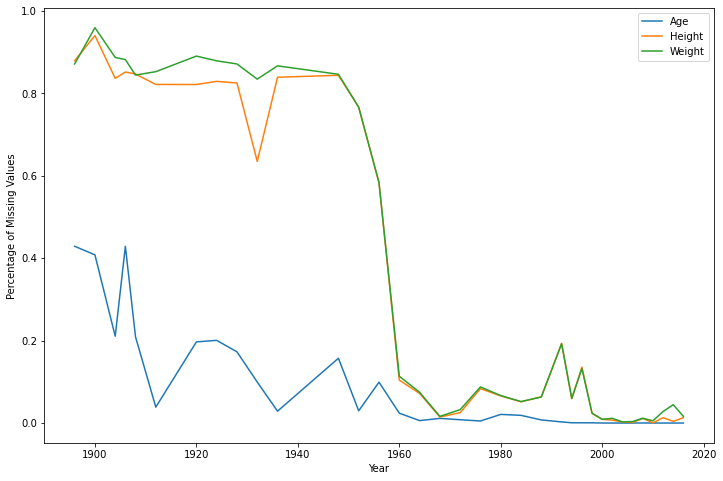

In [7]:
# Show missing evolution of Age, Height and Weight
M1.show_missing_evolution(df)

##### Data Pre-processing

We will now apply all the data pre-processing steps in one single function. For transparency purposes we will however explain what this function does over the input dataframe:

- Remove observations before 1960 based on the previous plot.
- Split Athletics sport into sub-sports based on its events. This is due to the fact that athletics covers a very wide range of sport events which are probably not comparable.
- Replace missing values with the average feature values at Sport, Sex and Year level. This can give us an approximation of the height, age and year of each athlete that has missing data.
- We will only foocus on one olympic game season. For this analysis we have choosen the summer games since none of our team-mates is especially keen of winter sports.
- We will only focus our analysis on sports that have competed during the last Olympic games. This is motivated due to the fact that our test data will be the last Olympic games and we want both data set (train and test) to have the same sports.
- Construct one of the target variables (1 if an athlete has won a medal, 0 otherwise). This will be used to identify team sports as well.
- Convert team sports it one athlete. This is done to reduce the number of medals won by sport, and that it does not depend on the number of team members.
- Add column with the number of medals won per country at sport and sex level.

In [38]:
df_clean = M1.data_preprocessing(df)

## 1. What probability do we have of winning a medal at a given sport?

##### Generate Dictionary that maps country and sport to number of medals won

For later on, it will be very comfortable to have a dictionary where we can quickly access the number of medals won by a country, sport and sex.

In [9]:
medals_country_dict = M1.generate_mapping_table_country_sport_sex(df_clean)

##### Standardize features

We have standardized our data since the main features we will be using throughout our analyis have different units and magnituude

In [10]:
df_standardized = M1.standardize_features(df_clean)

##### Generate training and testing dataframe samples

We have decided to split the data as follows:

- **Training Sample:** All observations from 1960 until 2012
- **Testing Sample:** All observations from 2016

The motivation for this decision is that our model should be able to do predictions over the upcoming olympic games given a set of historical olympic game features. Any other random split would not have made too much sense from our point of view. 

In [11]:
df_train, df_test = M1.generate_sample_split(df_standardized)

##### Generate a set of additional columns to increase the possible degrees of our logistic regression fit

In order to train the logistic regression model (to predict the probability of winning a medal or not) we will also investigate how well the model performs if we consider higher degree orders of our classification model

In [37]:
temp_list = M1.extend_dataset_features([df_train, df_test])
df_train_extended = temp_list[0]
df_test_extended = temp_list[1]

### Using all the different features (including the new ones we have just generated), which gives the best performances at sport and sex level? 

1. Compute the optimized set of theta values for the given input training set
2. From all these potential theta values, which one gives the best results over the test data?

##### 1. Compute the optimized set of theta values for the given input training set

In [13]:
feature_permutations = {'featureBag_1': ['Age', 'Height', 'Weight', 'Medals_per_country', 'Age^2', 'Height^2', 'Weight^2', 
                                         'Medals_per_country^2', 'Age*Height', 'Age*Weight', 'Age*Medals_per_country', 
                                         'Height*Weight', 'Height*Medals_per_country', 'Weight*Medals_per_country', 'Age^3', 
                                         'Height^3', 'Weight^3', 'Medals_per_country^3'], 
                        'featureBag_2': ['Age', 'Height', 'Weight', 'Medals_per_country'], 
                        'featureBag_3': ['Age', 'Height', 'Weight', 'Medals_per_country', 'Age^2', 'Height^2', 'Weight^2', 
                                         'Medals_per_country^2', 'Age*Height', 'Age*Weight', 'Age*Medals_per_country', 
                                         'Height*Weight', 'Height*Medals_per_country', 'Weight*Medals_per_country'], 
                        'featureBag_4': ['Age^2', 'Height^2', 'Weight^2', 'Medals_per_country^2'], 
                        'featureBag_5': ['Height', 'Weight', 'Medals_per_country'], 
                        'featureBag_6': ['Age', 'Height', 'Weight', 'Age^2', 'Height^2', 'Weight^2'], 
                        'featureBag_7': ['Age*Height', 'Age*Weight', 'Age*Medals_per_country', 
                                         'Height*Weight', 'Height*Medals_per_country', 'Weight*Medals_per_country'], 
                        'featureBag_8': ['Age^3', 'Height^3', 'Weight^3', 'Medals_per_country^3'], 
                        'featureBag_9': ['Medals_per_country', 'Medals_per_country^2', 'Medals_per_country^3']}

In [14]:
hyperparameter_thetas = M1.optimal_feature_combinations(df_train_extended, feature_permutations)

Model 0
Features inspected: ['Age', 'Height', 'Weight', 'Medals_per_country', 'Age^2', 'Height^2', 'Weight^2', 'Medals_per_country^2', 'Age*Height', 'Age*Weight', 'Age*Medals_per_country', 'Height*Weight', 'Height*Medals_per_country', 'Weight*Medals_per_country', 'Age^3', 'Height^3', 'Weight^3', 'Medals_per_country^3']
Sex: F
Sex: M
Model 1
Features inspected: ['Age', 'Height', 'Weight', 'Medals_per_country']
Sex: F
Sex: M
Model 2
Features inspected: ['Age', 'Height', 'Weight', 'Medals_per_country', 'Age^2', 'Height^2', 'Weight^2', 'Medals_per_country^2', 'Age*Height', 'Age*Weight', 'Age*Medals_per_country', 'Height*Weight', 'Height*Medals_per_country', 'Weight*Medals_per_country']
Sex: F
Sex: M
Model 3
Features inspected: ['Age^2', 'Height^2', 'Weight^2', 'Medals_per_country^2']
Sex: F
Sex: M
Model 4
Features inspected: ['Height', 'Weight', 'Medals_per_country']
Sex: F
Sex: M
Model 5
Features inspected: ['Age', 'Height', 'Weight', 'Age^2', 'Height^2', 'Weight^2']
Sex: F
Sex: M
Model 6

In [15]:
hyperparameter_thetas['featureBag_2']['M']

,Intercept,Age,Height,Weight,Medals_per_country
Archery,-1.263956,-0.338999,-0.097871,0.090982,4.022280
Athletics Endurance,-2.873725,-0.060190,0.026015,0.143287,1.020414
Athletics Sprints,-3.316379,-0.030952,0.264165,0.366035,0.449914
Athletics Throws,-3.008692,0.060549,0.461448,0.053348,1.513966
Badminton,-1.069912,-0.063780,-0.031614,-0.192227,4.040050
Basketball,-3.326468,-1.018428,1.022995,0.764390,3.796012
Beach Volleyball,-3.095074,0.215885,0.252813,0.540710,0.606925
Boxing,-1.955068,0.064236,0.105702,0.101900,1.147090
Canoeing,-2.316584,-0.003184,-0.150159,0.709292,1.543597
Cycling,-3.037151,-0.064725,0.012476,0.900109,1.766603


##### 2. From all these potential theta values, which one gives the best results over the test data?

##### We now have the theta values for each sport. Several observations can already be made from the previous:

- Ideal theta values will be estimated at sport level (for some sports the country might have more influence, in other sport we might prefer giving more weight to the variable height, etc.)
- In general, the variable that seems to have most weight on the prediction of winning a gold medal or not is Medals_per_country (this theta has the highest weight).
- The other features which should intuitevely also be relevant (age, height, weight) seem to be less relevant. This is also an expected (although undesired) result since already the best althelets arrive at the olympics, regardless of their physical features. Another relevant and probably more insightful variable would be the number of training hours, age at which they started practicing the sport, etc.


##### Apply model on test data and see how well is predicts medal winners (we will compute performance using f1-score, which considers both recall and precision)

In [16]:
df_female_performance, df_male_performance = M1.model_performance(df_test_extended, hyperparameter_thetas, 
                                                                  print_evolution=True)
df_performance = {'F': df_female_performance,
                  'M': df_male_performance}

featureBag_1
Sex:  M
Sex:  F
featureBag_2
Sex:  M
Sex:  F
featureBag_3
Sex:  M
Sex:  F
featureBag_4
Sex:  M
Sex:  F
featureBag_5
Sex:  M
Sex:  F
featureBag_6
Sex:  M
Sex:  F
featureBag_7
Sex:  M
Sex:  F
featureBag_8
Sex:  M
Sex:  F
featureBag_9
Sex:  M
Sex:  F


In [108]:
df_performance['M']

,Model features,Archery,Athletics Endurance,Athletics Sprints,Athletics Throws,Badminton,Basketball,Beach Volleyball,Boxing,Canoeing,...,Swimming,Table Tennis,Taekwondo,Tennis,Trampolining,Triathlon,Volleyball,Water Polo,Weightlifting,Wrestling
0,featureBag_1,0.444444,0.066667,0.055556,0.000000,0.2,0.333333,0.4,0.095238,0.108108,...,0.072727,0.666667,0.105263,0.000000,0.000000,0.333333,0.666667,0.333333,0.148148,0.039216
1,featureBag_2,0.222222,0.066667,0.000000,0.133333,0.2,0.666667,0.8,0.095238,0.054054,...,0.072727,0.666667,0.210526,0.285714,0.000000,0.000000,0.666667,0.333333,0.148148,0.039216
2,featureBag_3,0.444444,0.000000,0.111111,0.000000,0.2,0.333333,0.8,0.047619,0.054054,...,0.072727,0.666667,0.105263,0.000000,0.333333,0.666667,0.666667,0.333333,0.148148,0.000000
3,featureBag_4,0.222222,0.066667,0.000000,0.133333,0.2,0.333333,0.8,0.047619,0.108108,...,0.109091,0.000000,0.210526,0.000000,0.333333,0.333333,0.666667,0.333333,0.074074,0.000000
4,featureBag_5,0.222222,0.066667,0.000000,0.133333,0.2,0.666667,0.8,0.095238,0.054054,...,0.109091,0.666667,0.210526,0.285714,0.000000,0.000000,1.000000,0.333333,0.148148,0.039216
5,featureBag_6,0.222222,0.000000,0.000000,0.000000,0.0,0.333333,0.8,0.095238,0.054054,...,0.000000,0.222222,0.210526,0.000000,0.333333,0.000000,0.666667,0.333333,0.074074,0.000000
6,featureBag_7,0.000000,0.066667,0.000000,0.133333,0.0,0.666667,0.8,0.095238,0.054054,...,0.036364,0.000000,0.210526,0.285714,0.333333,0.000000,0.666667,0.333333,0.148148,0.000000
7,featureBag_8,0.000000,0.066667,0.000000,0.133333,0.4,0.333333,0.8,0.095238,0.108108,...,0.109091,0.000000,0.210526,0.000000,0.333333,0.000000,0.666667,0.333333,0.148148,0.039216
8,featureBag_9,0.444444,0.000000,0.055556,0.000000,0.2,0.666667,0.4,0.095238,0.108108,...,0.109091,0.666667,0.315789,0.000000,0.666667,0.666667,1.000000,0.333333,0.074074,0.000000


##### Evaluate Model over a set of input variables 

In [17]:
sex = 'M'
country = 'ESP'
sport = 'Basketball'
age = 20
height = 200
weight = 100

M1.compute_probability_medal(sex, country, sport, age, height, weight, medals_country_dict, df_performance,
                             hyperparameter_thetas, df_clean=df_clean)

0.6429739404621343

##### Inspect features against target variable

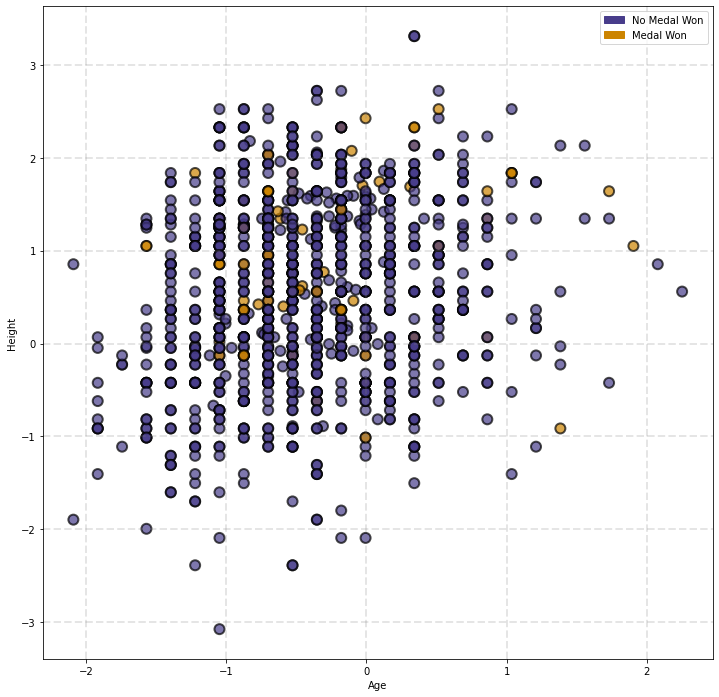

In [18]:
M1.plot_sport_features('Swimming', df_test, x_feature='Age', y_feature='Height')

## Which sport should we participate in the Olympics in?

We will now start looking into the models that can tell us what sport we are best suited for a given athlete. For this we have investigated the following models using a 5-fold cross validation approach, allowing us to decide which of the hyperparameters of each model would be best suited over the training sample (metric to choose which hyperparameter is best is the F1-score). From these best models we have then evaluated them over the test data sample (2016 Olympic games) to see which of the models would outperform the rest.

1. **Decision Tree Classifier:** Basic Classifier which sets up a set of decisions (controlled by the depth of the tree) which converts input features (branches) into categories or target values (leaves) through a set of boolean if statements. One of the advantages os such models is that it is easily reproducible and therefore can be validated easily. 
2. **Random Forest Classifier:** The basic principal is very similar to the decision tree classifier. The main difference is that the random forest classifies based on some set of bootstraps over the initial data set. This allows our model to be more flexible when predicting unseen data since it trains over more data sets than the basic decision tree classifier.
3. **Logisitic Regression:** The main difference between our model and this logistic regression is that this model will be used to classify between multiple categories. In the previous model we were classifying a athelete between winning or not a medal. The method used in this case is the one-vs-rest approach, i.e. basically the logistic regression classifies a given catgegory into 1 and all the rest into 0 and generates a normal logisit regression over these binary categories.
4. **K-Nearest Neighbours:** One of the most popular classification models used throughout the data science community. The principal is very straight forward and easy: Given a set of clusters (choosen by the user if the "real" number of clusters is not known, or inferred by the data, in our case the number of groups should ideally be equal to the number of sport types), look for groups over which a specific distance measure is minimized.
5. **Linear SVC:** Algorithm to classify observations into categories according to some features by maximizing the margin between two different category examples.

These models will be evaluated similarly to the previous model, i.e. using the following metrics:

1. **Accuracy:** Percentage of atheletes correctly classified

\begin{align}
Accuracy = \frac{True Positives + True Negatives}{True Positives + True Negatives + False Positives + False Negatives} 
\end{align}

2. **Weighted precision:** Percentage of athelets correctly classified out of all positive results

\begin{align}
Precision = \frac{True Positives}{True Positives + False Positives} 
\end{align}

3. **Weighted recall:** Percentage of athlets correctly classified from all the athletes that have been assigned to a specific class

\begin{align}
Recall = \frac{True Positives}{True Positives + False Negatives} 
\end{align}

4. **Weighted F1:** Similarly as in the previous model selection, this will be the utlimate metric over which we will decide which model is the best. This metric combines the recall and precision, and for this reason is sometimes considered to be the most accurate metric to use.

\begin{align}
F1 = 2 \cdot \frac{recall \cdot precision}{recall + precision}
\end{align}

##### Convert sports into integer labels

In [35]:
le = LabelEncoder()
df_standardized['Sport_label'] = le.fit_transform(df_standardized.Sport)

##### Generate training and testing samples (we continue following the same approach as before):

As in the previous models, we will train our model over all the olympic game history and then apply the best hyper-parameters over the unseen 2016 Olympic Games

In [51]:
df_train_Female_X, df_train_Male_X, df_train_Female_Y, df_train_Male_Y, \
df_test_Female_X, df_test_Male_X, df_test_Female_Y, df_test_Male_Y = M1.generate_sample_split_advanced(df_standardized)

data_sets = {'F': {'Train': [df_train_Female_X, df_train_Female_Y],
                   'Test':  [df_test_Female_X,  df_test_Female_Y]},
             'M': {'Train': [df_train_Male_X, df_train_Male_Y],
                   'Test':  [df_test_Male_X,  df_test_Male_Y]}}

In [39]:
## Count sport labels
#train_counts_Female = df_train_Female_Y.value_counts()
#train_counts_Male = df_train_Male_Y.value_counts()
#
#test_counts_Female = df_test_Female_Y.value_counts()
#test_counts_Male = df_test_Male_Y.value_counts()
#
## Assign labels to actual sport names
#train_counts_Female.index = le.inverse_transform(train_counts_Female.index)
#train_counts_Male.index = le.inverse_transform(train_counts_Male.index)
#
#test_counts_Female.index = le.inverse_transform(test_counts_Female.index)
#test_counts_Male.index = le.inverse_transform(test_counts_Male.index)

In [53]:
# Define scoring dict to make loop easier to read afterwards
scoring = {
    'accuracy': 'accuracy',
    'weighted_precision': make_scorer(precision_score, average='weighted'),
    'weighted_recall': make_scorer(recall_score, average='weighted'),
    'weighted_F1': make_scorer(f1_score, average='weighted')
}

In [54]:
# Define model and hyperparameter list to make loop easier to read afterwards

classifiers = [("DT", DecisionTreeClassifier(), 
                {"max_depth": [3, 5, 10, None]}),
               
               ("RF", RandomForestClassifier(),
                {"max_depth": [3, 5, 10, None]}),
               
               ("LOGREG", LogisticRegression(),
                {"C": np.logspace(-5, 5, 5 + 5 + 1, base=10)}), 
               
               ("KNN", KNeighborsClassifier(), 
                {"n_neighbors_male": {"n_neighbors": np.append(np.logspace(0, 3, 3 + 0 + 1, base=10).astype("int"),
                                          np.sqrt(len(df_train_Male_X)).astype("int"))},
                 "n_neighbors_female": {"n_neighbors": np.append(np.logspace(0, 3, 3 + 0 + 1, base=10).astype("int"),
                                          np.sqrt(len(df_train_Female_X)).astype("int"))}}), 
               #("SVM", LinearSVC(), 
               # {"C": np.logspace(-5, 5, 5 + 5 + 1, base=10)})
              ]



In [56]:
models_Female, results_Female, models_Male, results_Male = M1.train_models(data_sets, classifiers, scoring)

F
Model: DT
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


Model: RF
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   41.5s finished


Model: LOGREG
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  4.0min finished
C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: KNN
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.5s finished


M
Model: DT
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.1s finished


Model: RF
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min remaining:    0.0s


Model: LOGREG
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  7.5min finished
C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: KNN
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   40.0s finished


In [58]:
results_Male

,params,accuracy,weighted_precision,weighted_recall,weighted_F1,Model,dummy_accuracy,dummy_weighted_precision,dummy_weighted_recall,dummy_weighted_F1
0,{'max_depth': 3},0.263260,0.181940,0.263260,0.198626,DT,0.031035,0.066609,0.031035,0.039431
1,{'max_depth': 5},0.292669,0.213466,0.292669,0.220856,DT,0.031035,0.066609,0.031035,0.039431
2,{'max_depth': 10},0.329772,0.325275,0.329772,0.304810,DT,0.031035,0.066609,0.031035,0.039431
3,{'max_depth': None},0.266584,0.340210,0.266584,0.281883,DT,0.031035,0.066609,0.031035,0.039431
4,{'max_depth': 3},0.290100,0.214810,0.290100,0.198988,RF,0.031035,0.066609,0.031035,0.039431
5,{'max_depth': 5},0.333677,0.292048,0.333677,0.257399,RF,0.031035,0.066609,0.031035,0.039431
6,{'max_depth': 10},0.383495,0.405380,0.383495,0.343647,RF,0.031035,0.066609,0.031035,0.039431
7,{'max_depth': None},0.346030,0.424626,0.346030,0.353108,RF,0.031035,0.066609,0.031035,0.039431
8,{'C': 1e-05},0.121759,0.078399,0.121759,0.034903,LOGREG,0.031035,0.066609,0.031035,0.039431
9,{'C': 0.0001},0.251662,0.139222,0.251662,0.134024,LOGREG,0.031035,0.066609,0.031035,0.039431


##### Evaluate best hyper-parameters

We now have run all the models and computed their metric values using a 5-fold cross validation approach. As we can observe the results are not ideal (most models are not able to classify corrcetly). However we are always able to improve the results of the dummy classification which randomly assigns sports to athlets without looking into aby of their features. 

It is important to highlight that an accuracy  of ~30% is already pretty good since we are trying to classify athletes to some sport (we have more than 40 sports to classify between) solely based on a few features.

In [59]:
best_models_Female =  results_Female.loc[results_Female.groupby('Model')['weighted_F1'].idxmax()]
best_models_Male =  results_Male.loc[results_Male.groupby('Model')['weighted_F1'].idxmax()]

In [60]:
best_models_Female

,params,accuracy,weighted_precision,weighted_recall,weighted_F1,Model,dummy_accuracy,dummy_weighted_precision,dummy_weighted_recall,dummy_weighted_F1
2,{'max_depth': 10},0.349474,0.359594,0.349474,0.309587,DT,0.029419,0.099966,0.029419,0.038228
19,{'n_neighbors': 1},0.130935,0.230487,0.130935,0.132123,KNN,0.029419,0.099966,0.029419,0.038228
13,{'C': 1.0},0.347646,0.218627,0.347646,0.246400,LOGREG,0.029419,0.099966,0.029419,0.038228
7,{'max_depth': None},0.362952,0.426847,0.362952,0.355706,RF,0.029419,0.099966,0.029419,0.038228


In [61]:
best_models_Male

,params,accuracy,weighted_precision,weighted_recall,weighted_F1,Model,dummy_accuracy,dummy_weighted_precision,dummy_weighted_recall,dummy_weighted_F1
2,{'max_depth': 10},0.329772,0.325275,0.329772,0.304810,DT,0.031035,0.066609,0.031035,0.039431
19,{'n_neighbors': 1},0.101292,0.205611,0.101292,0.106831,KNN,0.031035,0.066609,0.031035,0.039431
13,{'C': 1.0},0.284076,0.176380,0.284076,0.195517,LOGREG,0.031035,0.066609,0.031035,0.039431
7,{'max_depth': None},0.346030,0.424626,0.346030,0.353108,RF,0.031035,0.066609,0.031035,0.039431


##### Let's now see how our champion models predict based on our test data at sport and sex level 

In [ ]:
models = {'F': models_Female, 
          'M': models_Male}

In [ ]:
evaluation_df = M1.evaluate_models(data_sets, models, le)

In [70]:
evaluation_df

C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,precision,recall,f1-score,support,Sex,Model
Archery,0.000000,0.000000,0.000000,76.0,F,DT
Athletics Endurance,0.438028,0.677560,0.532079,459.0,F,DT
Athletics Sprints,0.205797,0.554688,0.300211,512.0,F,DT
Athletics Throws,0.485000,0.729323,0.582583,133.0,F,DT
Badminton,0.000000,0.000000,0.000000,59.0,F,DT
...,...,...,...,...,...,...
Volleyball,0.105263,0.166667,0.129032,12.0,M,KNN
Water Polo,0.100000,0.083333,0.090909,12.0,M,KNN
Weightlifting,0.363128,0.427632,0.392749,152.0,M,KNN
Wrestling,0.216312,0.260684,0.236434,234.0,M,KNN


From the previous dataframe we can see that depending on the sport and sex, the evaulation metrics can behave better or worse. The champion model is evaluated over the overall performance of the model over all sport types

##### Decide which is the champion model 

In [72]:
evaluation_df.loc['overall'][['precision', 'recall', 'f1-score', 'Sex', 'Model']]

C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,precision,recall,f1-score,Sex,Model
overall,0.274093,0.341434,0.283723,F,DT
overall,0.391214,0.413366,0.397887,F,RF
overall,0.144636,0.236452,0.148133,F,LOGREG
overall,0.259370,0.242041,0.247230,F,KNN
overall,0.298768,0.340769,0.303445,M,DT
overall,0.401694,0.421731,0.407771,M,RF
overall,0.146488,0.270769,0.184091,M,LOGREG
overall,0.255744,0.240192,0.243197,M,KNN


### From the previous  dataframe we can conclude that the best model to predict which sport an athlete participated in is the Random Forest, for both male and female

Apply such models over our FDS team members we would get the following results:

1. Apply random forest to obtain the ideal sport (without setting a fixed max_depth of the branches)
2. Applying a logisitic regression to compute the probability of winning a medal

In [103]:
df_us = pd.DataFrame(index=['Tansel', 'Alessandro', 'Leonardo', 'Juan'], 
                  columns=['Year', 'Age', 'Height', 'Weight', 'Country', 'Sex'])

df_us['Year'] = [2016, 2016, 2016, 2016]
df_us['Age'] = [23, 26, 24, 25]
df_us['Height'] = [172, 173, 165, 180]
df_us['Weight'] = [57, 69, 55, 80]
df_us['Country'] = ['TUR', 'ITA', 'ITA', 'ESP']
df_us['Sex'] = ['F', 'M', 'M', 'M']

In [106]:
df = M1.predict_ideal_sport_and_prob(df_us, models, le, medals_country_dict, df_clean, df_performance, 
                                     hyperparameter_thetas)
df

,Year,Age,Height,Weight,Country,Sex,Sport_predict,P_Medal
Tansel,2016,23,172,57,TUR,F,Taekwondo,0.321129
Alessandro,2016,26,173,69,ITA,M,Sailing,0.111271
Leonardo,2016,24,165,55,ITA,M,Wrestling,0.101105
Juan,2016,25,180,80,ESP,M,Athletics Sprints,0.039841
